In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Set the style for visualizations
sns.set(style="darkgrid")


# Enable inline plotting for matplotlib
##
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete!")

Environment setup complete!


- **state[0]: return**

(price today-price yesterday)/price yesteday
  
- actions: buy, sell hold

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device count: 2
Current CUDA device: 0
Device name: Tesla T4


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


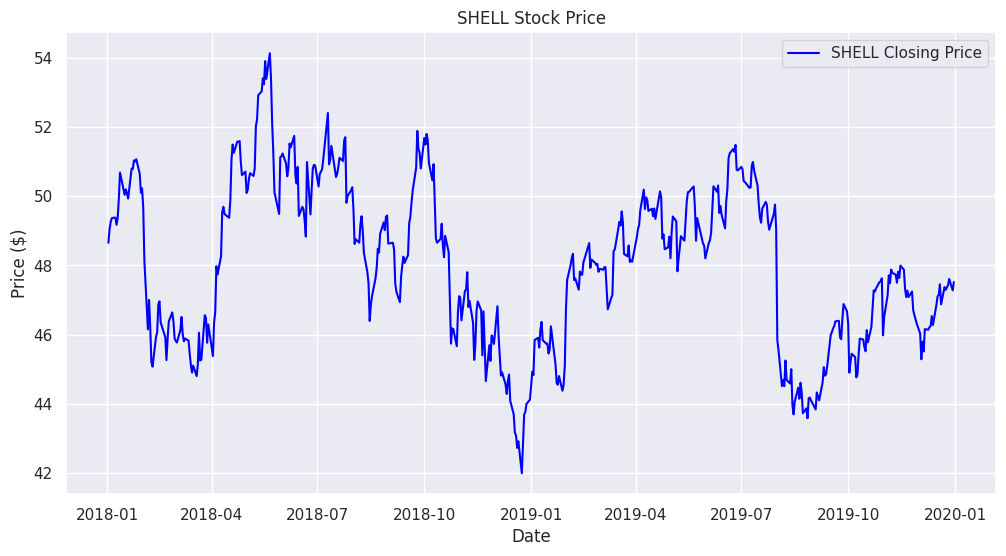

In [3]:
# Get stock data
data = yf.download("SHEL", start="2018-01-01", end="2020-01-01")

# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='SHELL Closing Price', color='blue')
plt.title('SHELL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,SHEL,SHEL,SHEL,SHEL,SHEL
Date,,,,,
2018-01-02,48.655605,48.691357,47.847541,47.911898,3470654
2018-01-03,49.048912,49.120427,48.569794,48.569794,3483320
2018-01-04,49.263443,49.392162,49.056062,49.070368,2638891
2018-01-05,49.370705,49.420762,49.039968,49.191929,2562434
2018-01-08,49.385014,49.399319,49.120429,49.199091,2741832


# Train-test split


For time series data (especially financial data), you should split first, then transform - but with important considerations:

## Correct Order of Operations
1. First split your raw data into train/test sets

2. Then transform/scale each set separately using only **training** statistics

3. Never let test data influence your transformations

## Why This Matters
1. Prevents data leakage (test set information contaminating training)

2. Simulates real-world conditions where future data is unavailable

3. Maintains the temporal order of financial data

In [4]:
# 1. First split data chronologically

split_idx = int(len(data) * 0.8)
train_raw = data.iloc[:split_idx]
test_raw = data.iloc[split_idx:]



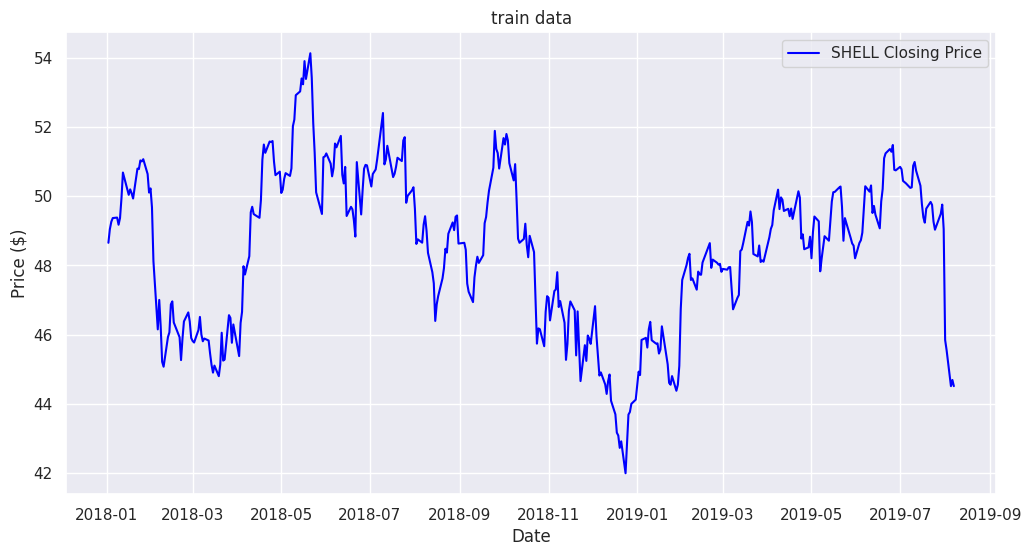

In [5]:
# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(train_raw['Close'], label='SHELL Closing Price', color='blue')
plt.title('train data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

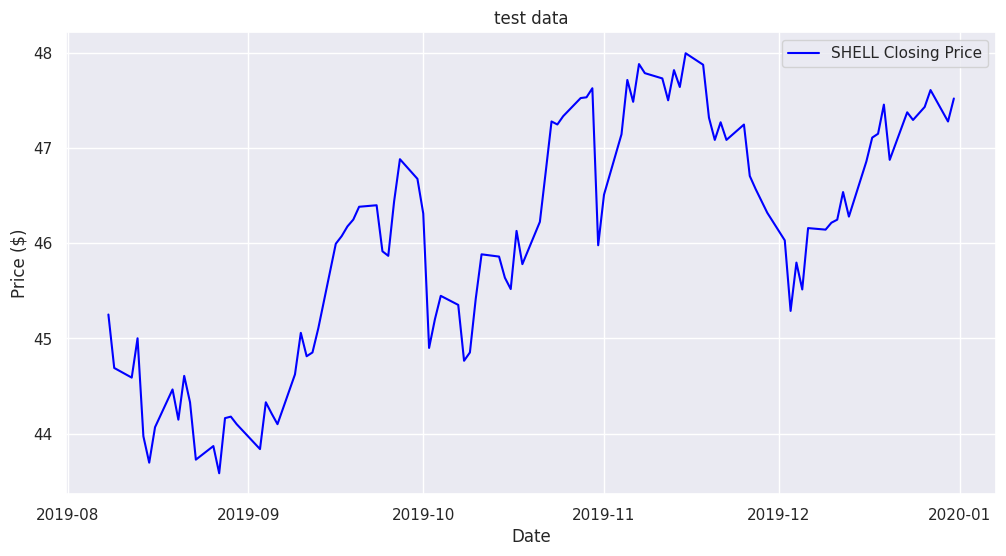

In [6]:
# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(test_raw['Close'], label='SHELL Closing Price', color='blue')
plt.title('test data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
print("Raw volume stats:")
print(train_raw['Volume'].describe())

Raw volume stats:
Ticker          SHEL
count   4.020000e+02
mean    3.240668e+06
std     1.218971e+06
min     1.032558e+06
25%     2.363634e+06
50%     2.991679e+06
75%     3.839714e+06
max     9.096246e+06


In [7]:
train_raw['pct_return'] = train_raw['Close'].pct_change()
train_raw=train_raw.fillna(0)

train_raw.describe()

Price,Close,High,Low,Open,Volume,pct_return
Ticker,SHEL,SHEL,SHEL,SHEL,SHEL,
count,402.000000,402.000000,402.000000,402.000000,4.020000e+02,402.000000
mean,48.520636,48.845622,48.241521,48.577026,3.240668e+06,-0.000141
std,2.262273,2.217476,2.314579,2.259097,1.218971e+06,0.012694
min,41.992702,43.204178,41.674688,41.977555,1.032558e+06,-0.065352
25%,46.709913,47.106561,46.313003,46.829559,2.363634e+06,-0.006816
50%,48.804184,49.220228,48.592832,48.974644,2.991679e+06,0.000850
75%,50.209163,50.457813,50.003333,50.266729,3.839714e+06,0.006888
max,54.135956,54.294015,53.837853,53.996282,9.096246e+06,0.044107


In [8]:
test_raw['pct_return'] = test_raw['Close'].pct_change()
test_raw=test_raw.fillna(0)

test_raw.describe()

Price,Close,High,Low,Open,Volume,pct_return
Ticker,SHEL,SHEL,SHEL,SHEL,SHEL,
count,101.000000,101.000000,101.000000,101.000000,1.010000e+02,101.000000
mean,46.038682,46.293043,45.842493,46.090081,2.801697e+06,0.000527
std,1.250687,1.227326,1.263064,1.248437,1.005191e+06,0.009251
min,43.584011,43.853689,43.274685,43.393656,1.128056e+06,-0.034638
25%,45.002178,45.345348,44.757901,45.194131,2.170153e+06,-0.004843
50%,46.177654,46.397385,45.974387,46.224161,2.628202e+06,0.000697
75%,47.247414,47.432732,47.017792,47.192885,3.171885e+06,0.007441
max,47.996731,48.115976,47.779203,48.069255,6.554404e+06,0.019694


In [57]:
train_raw.isna().sum()

Price       Ticker
Close       SHEL      0
High        SHEL      0
Low         SHEL      0
Open        SHEL      0
Volume      SHEL      0
pct_return            0
dtype: int64

# Scaling dataset for numerical stability

When scaling time series data for neural networks (especially for online learning), you need to be careful about data leakage - where future information accidentally influences your scaling of past data. 



In [58]:
# from sklearn.preprocessing import StandardScaler

# price_scaler = StandardScaler()
# price_features = train_raw['Close'].values
# price_scaler.fit(price_features)
# standardized_price=price_scaler.transform(price_features)

# pct_return=train_raw['pct_return'].values

# train_data=np.column_stack([standardized_price,pct_return])

In [59]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# def create_global_scalers(train_raw):
#     """Create scalers fitted on the entire training set"""
#     # Initialize scalers
#     price_scaler = StandardScaler()  # For prices and highs
#     volume_scaler = MinMaxScaler()   # For volumes
    
#     # Fit on training data
#     price_features = train_raw[['Close', 'High']].values
#     price_scaler.fit(price_features)
    
#     volume_features = train_raw['Volume'].values.reshape(-1, 1)
#     volume_scaler.fit(volume_features)
    
#     return price_scaler, volume_scaler

# def apply_scaling(data, price_scaler, volume_scaler, ma_window=10):
#     """Apply pre-fit scalers to any dataset"""
#     prices = data['Close'].values
#     high = data['High'].values
#     volumes = data['Volume'].values
    
#     # Calculate MA (still using rolling window)
#     MA = np.array([np.mean(prices[max(0,t-ma_window):t+1]) for t in range(len(prices))])
    
#     # Scale features
#     price_features = price_scaler.transform(np.column_stack([prices, high]))
#     scaled_volumes = volume_scaler.transform(volumes.reshape(-1, 1))
    
#     return np.column_stack([price_features, MA, scaled_volumes])

# # Usage
# price_scaler, volume_scaler = create_global_scalers(train_raw)
# train_data = apply_scaling(train_raw, price_scaler, volume_scaler)
# test_data = apply_scaling(test_raw, price_scaler, volume_scaler)  # Same scalers!

## The Core Problem of global scaling
Standard scaling approaches use global statistics (whole-dataset mean/std or min/max), which is problematic because:

1. In real trading, you don't know future price ranges when scaling current data

2. Market regimes change - volatility and volume distributions shift over time

3. Using future statistics creates lookahead bias in backtesting

**Rolling window approach to scaling does not work yet. DO not use this cell**

In [60]:
# # 2. Apply rolling scaling SEPARATELY to each set
# def safe_rolling_scale(data, ma_window=10, scale_window=252):
#     """Modified version that respects dataset boundaries"""
#     prices = data['Close'].values
#     high = data['High'].values
#     volumes = data['Volume'].values
    
#     MA = np.zeros_like(prices)
#     scaled_prices = np.zeros_like(prices)
#     scaled_high = np.zeros_like(high)
#     scaled_volumes = np.zeros_like(volumes)
    
#     for t in range(len(data)):
#         # MA calculation remains same
#         lookback = max(0, t - ma_window)
#         MA[t] = np.mean(prices[lookback:t+1])
        
#         # Scaling uses only data up to current point IN THIS DATASET
#         price_window = prices[max(0, t-scale_window):t+1]
#         price_mean, price_std = price_window.mean(), price_window.std()
#         scaled_prices[t] = (prices[t] - price_mean) / (price_std + 1e-8)
        
#         high_window = high[max(0, t-scale_window):t+1]
#         high_mean, high_std = high_window.mean(), high_window.std()
#         scaled_high[t] = (high[t] - high_mean) / (high_std + 1e-8)
        
#         vol_window = volumes[max(0, t-scale_window):t+1]
#         vol_min, vol_max = vol_window.min(), vol_window.max()
#         scaled_volumes[t] = (volumes[t] - vol_min) / (vol_max - vol_min + 1e-8)
    
#     return np.column_stack((scaled_prices, scaled_high, MA, scaled_volumes))

# # 3. Apply to each dataset
# train_data = safe_rolling_scale(train_raw)
# test_data = safe_rolling_scale(test_raw)  # Uses its own isolated history

In [9]:
actions = {0: 'Buy', 1: 'Sell', 2: 'Hold'}

In [10]:
#takes action and updates cash and holdings accordingly

def state_transition_with_action(price, portfolio_state, action):
    
    cash= portfolio_state['cash']
    holdings= portfolio_state['holdings']

    # 2. Apply action (with validation)
    trade_size = 0.1  # 10% of cash/holdings
    new_cash, new_holdings = cash, holdings  # Default: hold
    
    if action == 0:  # Buy
        if cash > 0:  # Only buy if cash available
            max_affordable = cash / price
            buy_amount = min(trade_size * max_affordable, max_affordable)
            cost = buy_amount * price
            new_holdings = holdings + buy_amount
            new_cash = cash - cost
        else:
            action = 2  # Fallback to hold if no cash
    
    elif action == 1:  # Sell
        if holdings > 0:  # Only sell if holdings available
            sell_amount = trade_size * holdings
            new_cash = cash + (sell_amount * price)
            new_holdings = holdings - sell_amount
        else:
            action = 2  # Fallback to hold if no holdings

    
    return new_cash, new_holdings

### Some reward functions

In [24]:
def reward_function_gain(price, old_portfolio, new_portfolio):
    
    old_value = old_portfolio['cash'] + old_portfolio['holdings'] * price
    new_value = new_portfolio['cash'] + new_portfolio['holdings'] * price
    raw_return = (new_value - old_value) / old_value
    
    # Scale to [-1, 1] range (adjust clip values as needed)
#    scaled_reward = np.clip(raw_return * 1000, -1.0, 1.0)
    return raw_return * 1000

def log_reward_fees(price, old_portfolio, new_portfolio, action_t, transaction_cost_rate=0.001):
    
    old_value = old_portfolio['cash'] + old_portfolio['holdings'] * price
    new_value = new_portfolio['cash'] + new_portfolio['holdings'] * price
    
    log_return= np.log(new_value/old_value)
    
    
    # Cost applies only on buy or sell
    if action_t in [0, 1]:  # sell or buy
        transaction_cost = 0.1 * old_portfolio['cash'] * transaction_cost_rate
    else:
        transaction_cost = 0.0

    reward = log_return - transaction_cost
    return reward

## Deep Q Network agent with target network for stability

In [22]:
import torch
import torch.nn as nn
import numpy as np
import random
from collections import deque
import copy  # For deep copying the model

class DQNAgent:
    def __init__(self, state_dim, action_dim, target_update_freq=100):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995  # Slower decay recommended with target network
        self.target_update_freq = target_update_freq  # How often to update target net
        self.train_step_counter = 0  # To track when to update target
        self.training_steps_this_episode = 0
        
        # Main model and target model
        self.model = self._build_model()
        self.target_model = self._build_model()
        self._update_target_model()  # Initialize target with main model weights
        
        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        self.model.to(self.device)
        self.target_model.to(self.device)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters())
        
    def _build_model(self):
        """Build the neural network model"""
        model = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_dim)
        )
        return model
    
    def _update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.load_state_dict(self.model.state_dict())
        
    def save_model(self, path):
        """Save the model weights (state_dict) to a file."""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'target_model_state_dict': self.target_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon  # Save epsilon for continuity
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        """Load model weights (state_dict) from a file."""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint.get('epsilon', self.epsilon)  # Restore epsilon
        print(f"Model loaded from {path}")
        
    def act(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_dim - 1)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
        
    def reset_episode_stats(self):
        """Call at the start of each episode"""
        self.training_steps_this_episode = 0
    
    def train(self, batch_size=32):
        """Train the model on a batch of experiences"""
        if len(self.memory) < batch_size:
            return
        
        self.training_steps_this_episode += 1  # Increment counter
        
        # Sample batch from memory
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values using target network
        with torch.no_grad():  # No gradient calculation for target
            next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network periodically
        self.train_step_counter += 1
        if self.train_step_counter % self.target_update_freq == 0:
            self._update_target_model()
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()  # Return loss for monitoring

In [13]:
train_price=train_raw['Close'].to_numpy()
train_pct_return=train_raw['pct_return'].to_numpy()

test_price=test_raw['Close'].to_numpy()
test_pct_return=test_raw['pct_return'].to_numpy()

train_features=np.column_stack([train_price,train_pct_return])
test_features=np.column_stack([test_price,test_pct_return])

In [14]:
train_data_price_mean=np.mean(train_features[:,0])

### Read the cell underneath line by line and understand what is happening!!!

In [25]:
import copy 

# Initialize
state_dim = 1  # return
action_dim = 3  # buy, sell, hold
agent = DQNAgent(state_dim, action_dim)
portfolio = {"cash": 10000, "holdings": 0}
states = train_features[:,1].reshape(-1, 1)

# Performance tracking containers
portfolio_values = []
all_actions = []
episode_metrics = {
    'sharpe': [],
    'max_drawdown': [],
    'cumulative_return': [],
    'action_distribution': [],
    'loss':[],
    'rewards': [],
    'good_calls_ratio' : []
}

# Benchmark: Buy-and-Hold strategy
initial_price = train_features[0][0]
final_price = train_features[-1][0]
buy_and_hold_return = (final_price - initial_price) / initial_price

no_episodes=300

# Run episodes
for episode in range(no_episodes):
    # Reset portfolio each episode
    portfolio={'cash':10000, 'holdings':0}
    agent.reset_episode_stats()
    episode_losses = []  # Track losses for this episode
    
    
    total_reward = 0
    episode_portfolio_values = []
    episode_actions = []
    good_calls=0
    
    for t in range(len(states) - 1):
        
        state=states[t]
        
        # Get action
        action = agent.act(state)
        price_t=train_features[t][0]
        
        
        #if buy and price lower than mean or sell and price higher than mean --> good calls
        if action == 0 and price_t < train_data_price_mean or action == 1 and price_t > train_data_price_mean:
            good_calls += 1
        
        #store protfolio value before transitioning to compute reward
        old_portfolio_state = copy.deepcopy(portfolio)

        
        # Apply action to get next portfolio state
        portfolio['cash'], portfolio['holdings'] = state_transition_with_action(price_t, portfolio, action)
        
        
        # Calculate reward
        price_t_plus_1= train_features[t+1][0] if t < len(states) - 1 else train_features[t][0]
        
        
        reward = reward_function_gain(price_t_plus_1, old_portfolio_state, portfolio)
#        print(f"reward: {reward}")
        total_reward += reward
        
        # Track portfolio value and actions
        current_value = portfolio['cash'] + portfolio['holdings'] * price_t_plus_1  # cash + holdings*price
        episode_portfolio_values.append(current_value)
        episode_actions.append(action)
        
        # Store experience and train
        done = (t == len(states) - 2)
        next_state=states[t+1] if t < len(states) - 1 else state
        agent.remember(state, action, reward, next_state, done)
        loss = agent.train()  # Train and get loss
        if loss is not None:  # Only append if training occurred
            episode_losses.append(loss)

        
    # Store average loss for the episode
    avg_loss = np.mean(episode_losses) if episode_losses else 0
    episode_metrics['loss'].append(avg_loss)
    
    # Calculate metrics for this episode
    returns = np.diff(episode_portfolio_values) / episode_portfolio_values[:-1]
    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
    max_dd = (np.maximum.accumulate(episode_portfolio_values) - episode_portfolio_values).max()
    cum_return = (episode_portfolio_values[-1] - episode_portfolio_values[0]) / episode_portfolio_values[0]
    
    # Get action distribution
    unique, counts = np.unique(episode_actions, return_counts=True)
    action_dist = dict(zip(unique, counts / len(episode_actions)))
    calls_ratio= good_calls/len(episode_actions)
    
    # Store metrics
    episode_metrics['sharpe'].append(sharpe)
    episode_metrics['max_drawdown'].append(max_dd)
    episode_metrics['cumulative_return'].append(cum_return)
    episode_metrics['action_distribution'].append(action_dist)
    episode_metrics['rewards'].append(total_reward)
    episode_metrics['good_calls_ratio'].append(calls_ratio)
    
    # Print progress
    print(f"Episode {episode}: Return={cum_return:.2%} | Sharpe={sharpe:.2f} | good calls ratio= {calls_ratio} | total reward= {total_reward} | Training Steps={agent.training_steps_this_episode}")
    

agent.save_model(f"dqn_agent_{no_episodes}.pth")

Using device: cuda
Episode 0: Return=4.76% | Sharpe=0.35 | good calls ratio= 0.23690773067331672 | total reward= -4.842749607334181 | Training Steps=370
Episode 1: Return=-11.16% | Sharpe=-0.48 | good calls ratio= 0.19201995012468828 | total reward= 5.067278314558117 | Training Steps=401
Episode 2: Return=19.13% | Sharpe=1.08 | good calls ratio= 0.4937655860349127 | total reward= -0.8607977553740946 | Training Steps=401
Episode 3: Return=-7.54% | Sharpe=-0.25 | good calls ratio= 0.1546134663341646 | total reward= 7.805322007258166 | Training Steps=401
Episode 4: Return=9.50% | Sharpe=0.51 | good calls ratio= 0.5660847880299252 | total reward= 2.577849352945068 | Training Steps=401
Episode 5: Return=-6.66% | Sharpe=-0.34 | good calls ratio= 0.35910224438902744 | total reward= 18.495040413304498 | Training Steps=401
Episode 6: Return=8.50% | Sharpe=0.47 | good calls ratio= 0.35910224438902744 | total reward= 1.6879347393425435 | Training Steps=401
Episode 7: Return=5.37% | Sharpe=0.40 | 

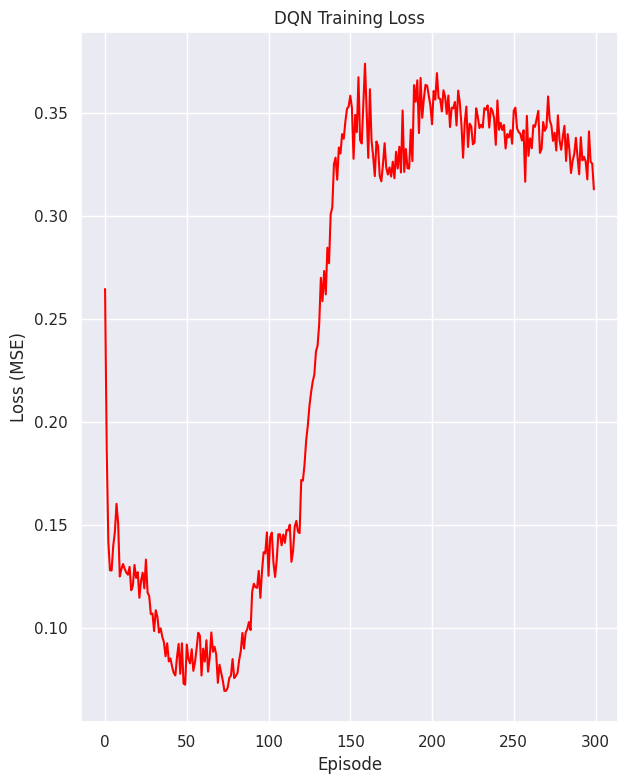

In [26]:
# Plot performance over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))


# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(episode_metrics['loss'], label='Training Loss', color='red')
plt.xlabel('Episode')
plt.ylabel('Loss (MSE)')
plt.title('DQN Training Loss')
plt.grid(True)


plt.savefig(f"loss_{no_episodes}.png")

plt.tight_layout()
plt.show()



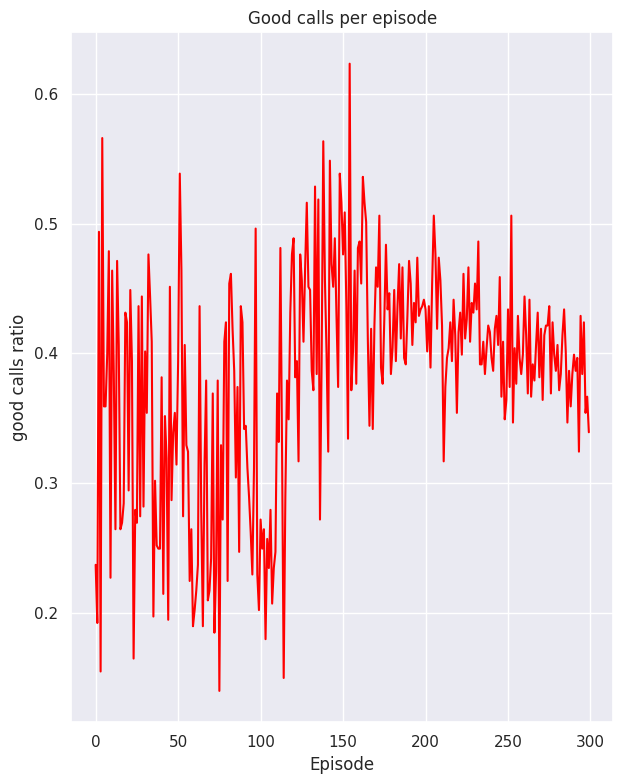

In [27]:
# Plot performance over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))


# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(episode_metrics['good_calls_ratio'], label='good_calls_ratio', color='red')
plt.xlabel('Episode')
plt.ylabel('good calls ratio')
plt.title('Good calls per episode')
plt.grid(True)



plt.tight_layout()
plt.show()


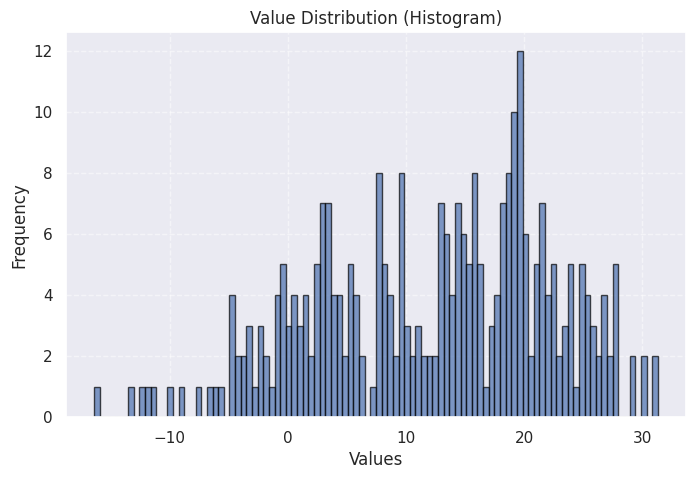

In [28]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(episode_metrics["rewards"], bins=100, edgecolor='black', alpha=0.7)
plt.title("Value Distribution (Histogram)")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

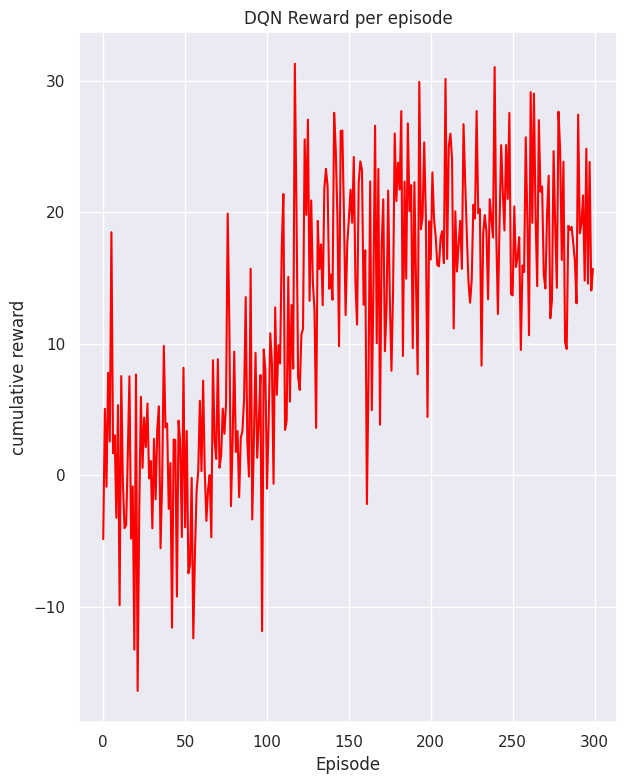

In [29]:
plt.figure(figsize=(12, 8))


# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(episode_metrics['rewards'], label='Training Loss', color='red')
plt.xlabel('Episode')
plt.ylabel('cumulative reward')
plt.title('DQN Reward per episode')
plt.grid(True)


plt.savefig(f"reward_{no_episodes}.png")

plt.tight_layout()
plt.show()



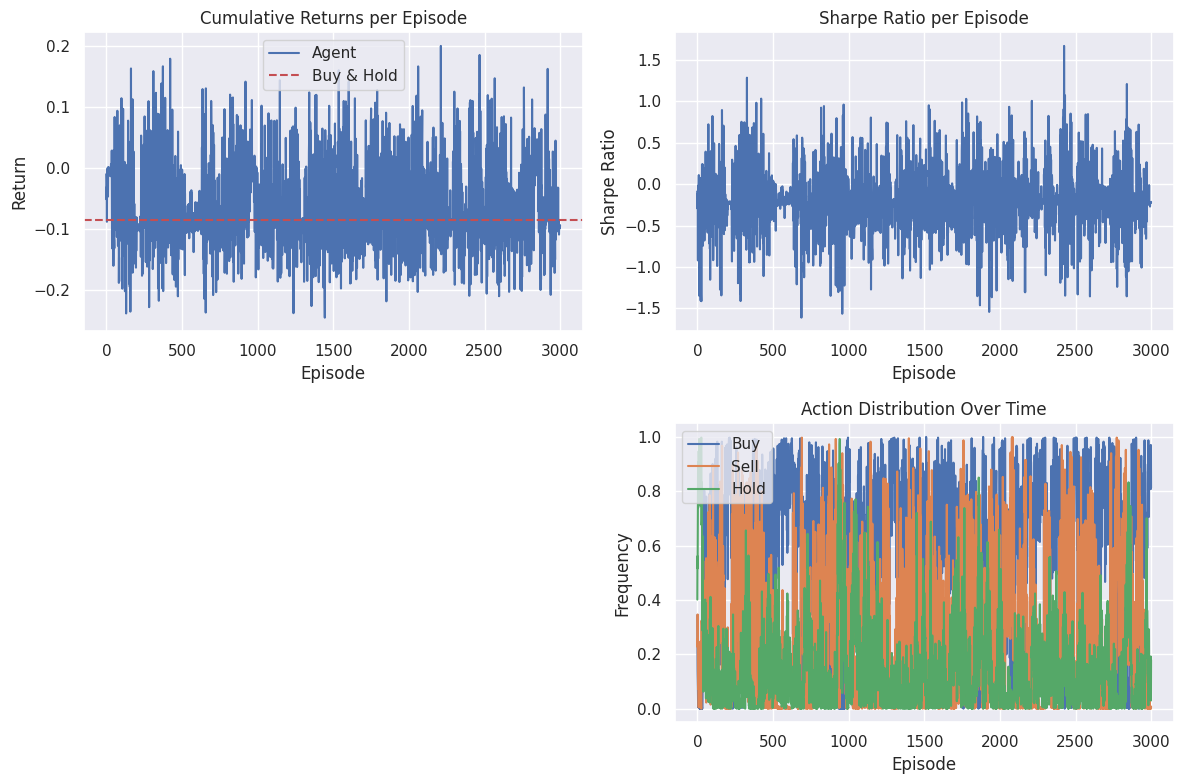

In [20]:
plt.figure(figsize=(12, 8))

# # Cumulative Returns
plt.subplot(2, 2, 1)
plt.plot(episode_metrics['cumulative_return'], label='Agent')
plt.axhline(y=buy_and_hold_return, color='r', linestyle='--', label='Buy & Hold')
plt.title('Cumulative Returns per Episode')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()

# Sharpe Ratio
plt.subplot(2, 2, 2)
plt.plot(episode_metrics['sharpe'])
plt.title('Sharpe Ratio per Episode')
plt.xlabel('Episode')
plt.ylabel('Sharpe Ratio')


# Action Distribution
plt.subplot(2, 2, 4)
action_counts = np.zeros((len(episode_metrics['action_distribution']), action_dim))
for i, dist in enumerate(episode_metrics['action_distribution']):
    for act, count in dist.items():
        action_counts[i, act] = count
for act in range(action_dim):
    plt.plot(action_counts[:, act], label=actions[act])
plt.title('Action Distribution Over Time')
plt.xlabel('Episode')
plt.ylabel('Frequency')
plt.legend()

# plt.savefig(f"action_distr_{no_episodes}.png")


plt.tight_layout()
plt.show()

### Underneath still needs adjustment for return only state space

In [73]:
    
# Initialize
portfolio = {"cash": 10000, "holdings": 0}

test_states=test_features[:,1].reshape(-1, 1)

portfolio_values = []
actions_taken = []
trade_history = []

# Disable exploration (no need for eval() on the agent)
original_epsilon = agent.epsilon
agent.epsilon = 0  # Set to 0 for deterministic evaluation

# Put models in evaluation mode (this is the correct way)
agent.model.eval()
agent.target_model.eval()

with torch.no_grad():  # Disable gradient calculations
    for t in range(len(test_states) - 1):
        
        action = agent.act(test_states[t])
        price_t=test_features[t][0]
        
        # Apply action to get next portfolio state
        portfolio['cash'], portfolio['holdings'] = state_transition_with_action(price_t, portfolio, action)


        # Track portfolio
        price_t_plus_1= test_features[t+1][0] if t < len(test_states) - 1 else test_features[t][0]
        current_value = portfolio['cash'] + portfolio['holdings'] * price_t_plus_1
        portfolio_values.append(current_value)
        actions_taken.append(action)

        # # Record trades (optional)
        # if action != 2:  # Not hold
        #     trade_history.append({
        #         'step': t,
        #         'action': action,
        #         'price': price_t,
        #         'shares': abs(next_state[5] - state[5]),
        #         'value': abs(state[4] - next_state[4])
        #     })


# Restore training settings
agent.model.train()
agent.target_model.train()
agent.epsilon = original_epsilon

# Calculate performance metrics
returns = np.diff(portfolio_values) / portfolio_values[:-1]
metrics = {
    'cumulative_return': (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0],
    'annualized_return': (1 + (portfolio_values[-1] - portfolio_values[0])/portfolio_values[0])**(252/len(test_states)) - 1,
    'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252),
    'max_drawdown': (np.maximum.accumulate(portfolio_values) - portfolio_values).max(),
    'win_rate': np.mean(np.array(returns) > 0),
    'action_distribution': {
        'buy': (np.array(actions_taken) == 0).mean(),
        'sell': (np.array(actions_taken) == 1).mean(),
        'hold': (np.array(actions_taken) == 2).mean()
    }
}


In [29]:
# def evaluate_agent(agent, test_states, initial_cash=10000):
    
#     # Initialize
#     portfolio = {"cash": initial_cash, "holdings": 0}
    
#     portfolio_values = []
#     actions_taken = []
#     trade_history = []
    
#     # Disable exploration (no need for eval() on the agent)
#     original_epsilon = agent.epsilon
#     agent.epsilon = 0  # Set to 0 for deterministic evaluation
    
#     # Put models in evaluation mode (this is the correct way)
#     agent.model.eval()
#     agent.target_model.eval()
    
#     with torch.no_grad():  # Disable gradient calculations
#         for t in range(len(test_states) - 1):
#             action = agent.act(test_states[t])
#             next_market_state = test_states[t + 1]
#             next_state = state_transition_with_action(state, action)
#             next_state[:4] = next_market_state  # Overwrite market data
            
#             # Track portfolio
#             current_value = next_state[4] + next_state[5] * next_state[0]
#             portfolio_values.append(current_value)
#             actions_taken.append(action)
            
#             # Record trades (optional)
#             if action != 2:  # Not hold
#                 trade_history.append({
#                     'step': t,
#                     'action': action,
#                     'price': state[0],
#                     'shares': abs(next_state[5] - state[5]),
#                     'value': abs(state[4] - next_state[4])
#                 })
            
    
#     # Restore training settings
#     agent.model.train()
#     agent.target_model.train()
#     agent.epsilon = original_epsilon
    
#     # Calculate performance metrics
#     returns = np.diff(portfolio_values) / portfolio_values[:-1]
#     metrics = {
#         'cumulative_return': (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0],
#         'annualized_return': (1 + (portfolio_values[-1] - portfolio_values[0])/portfolio_values[0])**(252/len(test_states)) - 1,
#         'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252),
#         'max_drawdown': (np.maximum.accumulate(portfolio_values) - portfolio_values).max(),
#         'win_rate': np.mean(np.array(returns) > 0),
#         'action_distribution': {
#             'buy': (np.array(actions_taken) == 0).mean(),
#             'sell': (np.array(actions_taken) == 1).mean(),
#             'hold': (np.array(actions_taken) == 2).mean()
#         }
#     }
    
#     return portfolio_values, actions_taken, metrics, trade_history

In [23]:
prices=[s[0] for s in test_features[:30]]
prices

##this appears as zero on the plot because prices are normalized, i.e. close to zero while portfolio returns are not!

[45.25175857543945,
 44.69020462036133,
 44.58881378173828,
 45.00217819213867,
 43.97266387939453,
 43.695064544677734,
 44.067840576171875,
 44.46443176269531,
 44.14716339111328,
 44.607200622558594,
 44.329593658447266,
 43.7267951965332,
 43.86956024169922,
 43.58401870727539,
 44.16302490234375,
 44.17888641357422,
 44.09957504272461,
 43.837825775146484,
 44.329593658447266,
 44.21061706542969,
 44.09957504272461,
 44.62305450439453,
 45.05929946899414,
 44.81340789794922,
 44.853065490722656,
 45.10688400268555,
 45.995216369628906,
 46.07453536987305,
 46.17764663696289,
 46.24903106689453]


=== Performance Metrics ===
Cumulative Return: 4.55%
Annualized Return: 11.75%
Sharpe Ratio: 1.22
Max Drawdown: 48346.19%
Win Rate: 54.55%

=== Action Distribution ===
Buy: 46.00%
Sell: 17.00%
Hold: 37.00%


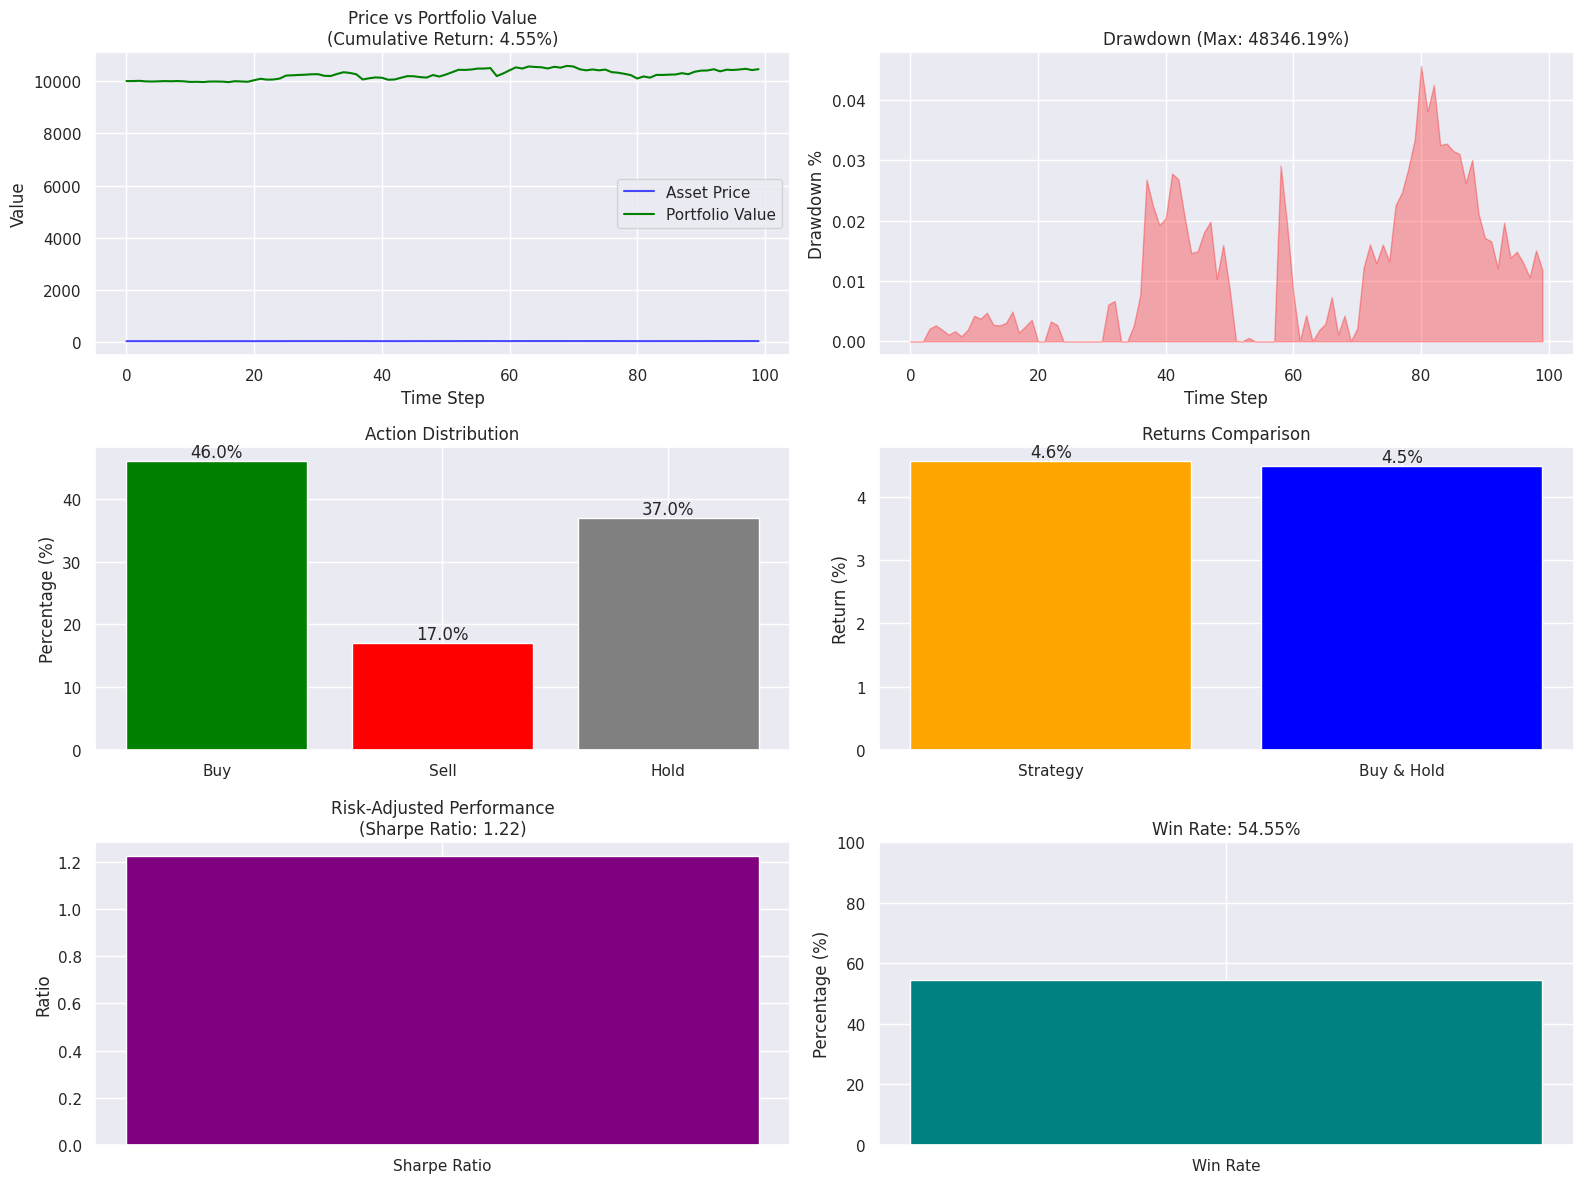

In [80]:
def plot_performance(test_states, portfolio_values, actions_taken, metrics):
    """Enhanced visualization of agent performance"""
    plt.figure(figsize=(16, 12))
    
    # Price and portfolio value comparison
    prices = [s[0] for s in test_states[:len(portfolio_values)]]
    plt.subplot(3, 2, 1)
    plt.plot(prices, label='Asset Price', alpha=0.7, color='blue')
    plt.plot(portfolio_values, label='Portfolio Value', color='green')
    plt.title(f'Price vs Portfolio Value\n(Cumulative Return: {metrics["cumulative_return"]:.2%})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    # Drawdown visualization
    plt.subplot(3, 2, 2)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdown = (running_max - portfolio_values) / running_max
    plt.fill_between(range(len(drawdown)), drawdown, color='red', alpha=0.3)
    plt.title(f'Drawdown (Max: {metrics["max_drawdown"]:.2%})')
    plt.xlabel('Time Step')
    plt.ylabel('Drawdown %')
    plt.grid(True)
    
    # Action distribution with percentages
    plt.subplot(3, 2, 3)
    action_names = ['Buy', 'Sell', 'Hold']
    action_percents = [
        metrics['action_distribution']['buy'] * 100,
        metrics['action_distribution']['sell'] * 100,
        metrics['action_distribution']['hold'] * 100
    ]
    bars = plt.bar(action_names, action_percents, color=['green', 'red', 'gray'])
    plt.title('Action Distribution')
    plt.ylabel('Percentage (%)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    plt.grid(True, axis='y')
    
    # Returns comparison
    plt.subplot(3, 2, 4)
    buy_hold_return = (prices[-1] - prices[0]) / prices[0]
    returns_comparison = {
        'Strategy': metrics['cumulative_return'] * 100,
        'Buy & Hold': buy_hold_return * 100
    }
    bars = plt.bar(returns_comparison.keys(), returns_comparison.values(),
                  color=['orange', 'blue'])
    plt.title('Returns Comparison')
    plt.ylabel('Return (%)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    plt.grid(True, axis='y')
    
    # Sharpe Ratio visualization
    plt.subplot(3, 2, 5)
    plt.bar(['Sharpe Ratio'], [metrics['sharpe_ratio']], color='purple')
    plt.title(f'Risk-Adjusted Performance\n(Sharpe Ratio: {metrics["sharpe_ratio"]:.2f})')
    plt.ylabel('Ratio')
    plt.grid(True, axis='y')
    
    # Win Rate visualization
    plt.subplot(3, 2, 6)
    plt.bar(['Win Rate'], [metrics['win_rate'] * 100], color='teal')
    plt.title(f'Win Rate: {metrics["win_rate"]:.2%}')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(True, axis='y')
    
    plt.savefig("eval_3k.png")
    plt.tight_layout()
    plt.show()

# Evaluation and reporting
# portfolio_values, actions_taken, metrics, _ = evaluate_agent(agent, test_data)

print("\n=== Performance Metrics ===")
print(f"Cumulative Return: {metrics['cumulative_return']:.2%}")
print(f"Annualized Return: {metrics['annualized_return']:.2%}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
print(f"Win Rate: {metrics['win_rate']:.2%}")
print("\n=== Action Distribution ===")
print(f"Buy: {metrics['action_distribution']['buy']:.2%}")
print(f"Sell: {metrics['action_distribution']['sell']:.2%}")
print(f"Hold: {metrics['action_distribution']['hold']:.2%}")

plot_performance(test_features, portfolio_values, actions_taken, metrics)

# Module 2.1: Market Data Collection and Preparation 
Collect and preprocess historical market data for a portfolio of assets. Clean the data, remove inconsistencies, and fill in missing values. Create a dataset that can be used for training and evaluating your DRL trading agent.
Give a short descriptive analysis of the data (e.g. histogram of returns, summary statistics)

# Module 2.2: Benchmark Policy Design

You will design at least one benchmark policy. Naturally, the higher the quality of the benchmark, the better you can evaluate the performance of the RL algorithm.

* Create one or more benchmark policies (e.g., a rule-based trading heuristic). You might opt for extremely simple baseline heuristics (single decision rule), but advanced solutions are assessed positively.
* Explain the decision rules you incorporate and how they anticipate the future.
* You can use this benchmark to evaluate the quality of the RL algorithms you design from here on.
* Note you can define multiple benchmarks. Simple decision rules offer a sanity check and a lower bound, more advanced heuristics may be competitive with RL.

# Module 3.1: RL Algorithms Assessment
Critically assess why dynamic programming and tabular Q-learning/SARSA would struggle to provide policies for the problem at hand. Explain what modifications would be needed for these methods to solve the problem, and what impact these modifications would have on the solution.

# Module 3.2: DRL Algorithm Selection and Implementation
Select a suitable DRL algorithm for your trading agent, taking into account the state representation, action space, and non-stationary nature of financial markets. Implement the chosen algorithm using a deep learning framework like TensorFlow or PyTorch.

# Module 4: Reward Function Design and Agent Training

Design a reward function that encourages your trading agent to achieve high returns while managing risk effectively. Train your agent using the prepared market data, adjusting hyperparameters and reward functions as needed to improve learning.

# Module 5: Agent Evaluation and Refinement

Evaluate the performance of your trained trading agent using out-of-sample market data. Analyze its risk-adjusted performance metrics and ensure that its performance is robust and not the result of overfitting or lookahead bias. Refine the agent and iterate through the previous steps as needed to improve its performance.

# Module 6: Trading Strategy Analysis and Interpretation

Analyze the trading strategies learned by your agent and interpret its decisions in the context of market dynamics and asset characteristics. Identify any interesting patterns or insights that can be gained from the agent's behavior.

# Module 7: Reflection and key findings
Summarize your key findings and reflect on your work.
* How well does your final model perform? Can you compare performance to other policies?
* What discrepancies exist between your model and a real-world variant of your problem?
* How did you address the dimensionality challenges? 
* What computational limits did you encounter?
* What future improvement steps could be taken?

# Module 8: Bonus
Write the report using overleaf/ latex. Add all charts and follow this structure:
- Introduction
- Literature Review
(very short on existing literature on deep RL trading strategies)
- Theoretical foundations
(very short on the algo you used, likely Deep RL. No need to explain all concepts from RL again.)
- Data
(very short, the data you used, plus some summary statistics)
- Implementation
(the exact implementation you did. Be very specific here, what parameters, how many training iterations)
- Results
(outcome and interpretation of results)
- Conclusion
(summary and next steps)
- Bibliography 
- Appendix: Code (or link to github for the code)

For all group assignments and presentations, it holds that you should hand in/present your own and original work, in line with the Rules & Guidelines of the Examination Board. You have to add an “author contribution & use of AI statement” to the group assignment.

# Author contribution statement
The author contribution statement should include who did what (tasks) and what was the relative contribution of each group member to the overall contribution (percentage). Also, all group members should agree on the final version of the assignment.

## Example author contribution statement:
* Name group member 1: Wrote the introduction of the report, produced the mathematical model of Module 1, downloaded and cleaned the data, produced output statistics and wrote answers 1.1 and 2.3. She debugged the Python code to make the mathematical program work. She read the final version of the report and made final edits. [20%]
* Name group member 2: … [30%]

# AI statement
The use of AI statement should show if and how you used AI in your assignment. For this course, you are only allowed to use AI, such as ChatGPT, to spell-check or grammar check your writing. You are not allowed to use AI to provide you with (partial) answers, and in particular the questions on summarizing the literature or providing you with code.

What is not allowed (with exception of the approved use for spelling and grammar checking):
* Use of AI to assist with (group) assignments. Completing assignments should be done by yourselves according to the instructions provided, to meet the learning outcomes of the course and the master program.
* Use of AI to write (part of) a literature review. The ability to independently formulate ideas, theories, and/or research questions is an important part of the learning goals of the master program and this course.
* Use AI to find relevant literature. Also this is an essential task for you to do by yourself in order to fulfill the learning outcomes of this course and the master program.
* Use AI to assist you with writing code (e.g., Python). Again this is an essential task for you to do by yourself to reach the learning outcomes of this course and the master program.
Whenever you are unsure whether a specific use of ChatGPT or another AI tool is allowed, please contact one of the lecturers. 

## Example of AI statement: 
* We declare that no content produced by AI technology has been presented as our own work (both in reporting and coding)
* We declare that we used ChatGPT 3.5 to improve writing at the sentence level and to better express transitions between paragraphs.
Note: An extra oral assessment may be part of each assignment as a verification of the authenticity and contribution. Such an oral assessment could also be randomly assigned to a group